### Using Pandas together with SQL

In [4]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 5)

In [5]:
# Install the SQLAlchemy library if it is not installed
!sudo -H pip3 install -U sqlalchemy

Requirement already up-to-date: sqlalchemy in /usr/local/lib/python3.5/dist-packages


### Importing into DataFrames using read_sql

The `read_sql` function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [6]:
from sqlalchemy import create_engine

In [7]:
conn_string_imdb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='imdb'
)
engine_imdb = create_engine(conn_string_imdb)

#### Retrieve the first 10 lines from the actors table 

In [8]:
query = '''
SELECT * FROM actors LIMIT 10
'''

In [9]:
df_actors = pd.read_sql(query, con=engine_imdb)

In [10]:
df_actors

,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
5,7,Félix,'El Gato',M
6,8,Marcial,'El Jalisco',M
7,9,José,'El Morito',M
8,10,Francisco,'El Niño de la Manola',M
9,11,Víctor,'El Payaso',M


#### Retrieve the number of movies per year

In [11]:
query = '''
SELECT year, COUNT(*) AS num_movies, COUNT(rank) AS rated_movies
FROM movies 
GROUP BY year
ORDER BY year
'''

In [12]:
df_movies = pd.read_sql(query, con=engine_imdb)

In [13]:
df_movies.head(5)

,year,num_movies,rated_movies
0,1888,2,0
1,1890,3,1
2,1891,6,6
3,1892,9,9
4,1893,2,1


Let's try to plot the results.

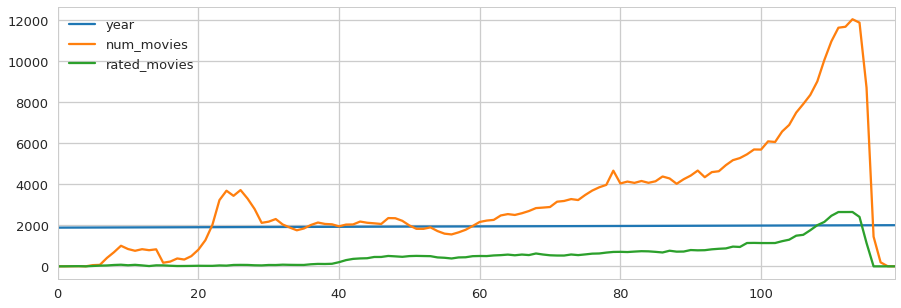

In [14]:
df_movies.plot()

We have a couple of issues. We also plotted the year as a line, and we do not have it as the label of the x-axis. For that, we need to convert the year into a proper datetime variable, and then make it the index for the dataframe.

In [15]:
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
df_movies2 = df_movies.set_index('year')

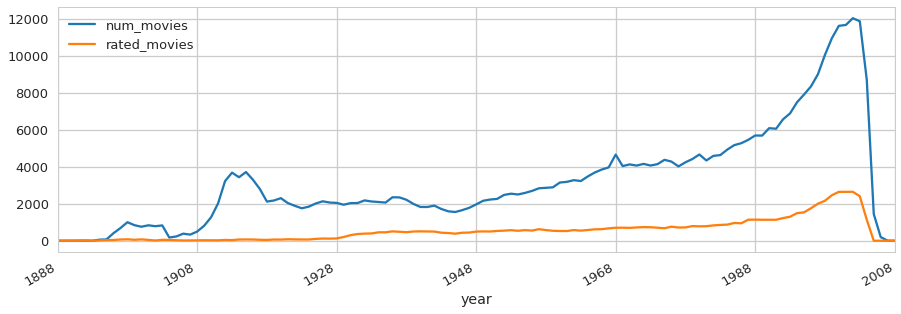

In [16]:
df_movies2.plot()

### Exercise

* Connect to the Facebook database, and use the `MemberSince` variable from the `Profiles` table to plot the growth of Facebook users.
* (_Learn something new_) Use the [cumsum()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cumsum.html) function of Pandas and plot the total number of registered users over time.

In [ ]:
# your code here

### Further Examples with SQL and Pandas

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [ ]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

In [ ]:
polviews_by_gender = '''
SELECT Sex, `Political Views` AS PoliticalViews, COUNT(*) AS cnt 
FROM Profiles 
WHERE Sex IS NOT NULL AND `Political Views` IS NOT NULL 
GROUP BY Sex, `Political Views`  
ORDER BY  `Political Views`, Sex
'''


And let's get the dataframe:

In [ ]:
df = pd.read_sql(polviews_by_gender, con=engine_fb)
df

In [ ]:
# Let's plot this!
# Bleh, this is really fugly...
# Remember that the index of the dataframe becomes the default x-axis
df.plot(kind='bar')

In [ ]:
# Pivot, baby!
# Now the index contains the Political Views, which will be our x-axis
dfp = df.pivot_table(index='PoliticalViews', columns='Sex', values='cnt')
dfp

In [ ]:
dfp.plot(kind='bar')

In [ ]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp = dfp / dfp.sum()
dfp

In [ ]:
dfp.plot(kind='bar')

In [ ]:
# OK, now let's try to re-order the list of results according to the logical structure
neworder = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other']
newindex = sorted(dfp.index, key=lambda x: neworder.index(x))
dfp = dfp.reindex(newindex)
dfp

In [ ]:
dfp.plot(kind='bar')

### Facebook, Favorite Books, and Political views

In [ ]:
books = '''
SELECT F.FavoriteBook, P.`Political Views` AS PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks F ON F.ProfileID = P.ProfileId  
WHERE `Political Views` IS NOT NULL AND F.FavoriteBook IS NOT NULL 
      AND (`Political Views` = 'Liberal' OR `Political Views` = 'Conservative')
GROUP BY F.FavoriteBook, P.`Political Views`
'''

In [ ]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

In [ ]:
dfp = df_books.pivot_table(index='FavoriteBook', columns='PoliticalViews', values='cnt')
dfp.head(10)

In [ ]:
# If we compute the sums, we will see that we have very different 
# number of likes per political view, due to imbalance in the population
dfp.sum()

In [ ]:
# Normalize the values, so that each column sums up to 1.0
dfp = dfp / dfp.sum()
dfp.head(20)

In [ ]:
dfp["Liberal_To_Conservative"] = dfp["Liberal"]  / dfp["Conservative"] 
dfp["Conservative_To_Liberal"] = dfp["Conservative"]  / dfp["Liberal"] 

In [ ]:
liberal_books = dfp[["Liberal_To_Conservative"]].sort_values("Liberal_To_Conservative", ascending=False).head(10)
liberal_books

In [ ]:
conservative_books = dfp[["Conservative_To_Liberal"]].sort_values("Conservative_To_Liberal", ascending=False).head(10)
conservative_books

In [ ]:
conservative_books.plot(kind='bar')

### Inserting Data in a Database using Pandas

In [ ]:
# Read the CSV file
restaurants = pd.read_csv('data/restaurant.csv.gz', encoding="utf-8", dtype="unicode")

In [ ]:
# Usual bookkeeping regarding datatypes
restaurants["GRADE DATE"] = pd.to_datetime(restaurants["GRADE DATE"], format="%m/%d/%Y")
restaurants["RECORD DATE"] = pd.to_datetime(restaurants["RECORD DATE"], format="%m/%d/%Y")
restaurants["INSPECTION DATE"] = pd.to_datetime(restaurants["INSPECTION DATE"], format="%m/%d/%Y")
restaurants["SCORE"] = pd.to_numeric(restaurants["SCORE"])
restaurants["BORO"] =  pd.Categorical(restaurants["BORO"], ordered=False)
restaurants["GRADE"] =  pd.Categorical(restaurants["GRADE"], categories = ['A', 'B', 'C'], ordered=True)
restaurants["VIOLATION CODE"] =  pd.Categorical(restaurants["VIOLATION CODE"], ordered=False)
restaurants["CRITICAL FLAG"] =  pd.Categorical(restaurants["CRITICAL FLAG"], ordered=False)
restaurants["ACTION"] =  pd.Categorical(restaurants["ACTION"], ordered=False)
restaurants["CUISINE DESCRIPTION"] =  pd.Categorical(restaurants["CUISINE DESCRIPTION"], ordered=False)

In [ ]:
# Connect to the MySQL, but without selecting a database
conn_string = 'mysql://{user}:{password}@{host}:{port}/'.format(
    user='root', password='dwdstudent2015', 
    host = 'localhost', port=3306)
engine = create_engine(conn_string)

In [ ]:
# Create the database where we want to store the data
# Do not worry about the Warning if the database already exists
engine.execute('CREATE DATABASE IF NOT EXISTS nyc_restaurant_inspections')
engine.execute('USE nyc_restaurant_inspections')

In [ ]:
# We drop the table if it is already there
engine.execute('DROP TABLE IF EXISTS inspections')
# Store the dataframe as a SQL table, using the to_sql command
restaurants.to_sql(name='inspections', if_exists='replace', index=False, con=engine, chunksize=1000)

In [ ]:
# And then we can just retrieve it from the database
df = pd.read_sql("SELECT * FROM inspections LIMIT 100", con=engine)
df.head(5)